<a href="https://colab.research.google.com/github/Harshitmaury123/Machine_Learning_Lab/blob/main/LAB4_task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

,file,column,treatment,unique_or_bins,bins_used,entropy_bits
0,Housing,price,continuous,21,21.0,3.591157
1,Housing,area,continuous,22,22.0,3.495153
2,Housing,stories,categorical,4,NaN,1.601335
3,Housing,bedrooms,categorical,6,NaN,1.578376
4,Housing,furnishingstatus,categorical,3,NaN,1.557256
5,Housing,parking,categorical,4,NaN,1.547615
6,Housing,bathrooms,categorical,4,NaN,0.944786
7,Housing,basement,categorical,2,NaN,0.934477
8,Housing,airconditioning,categorical,2,NaN,0.899528
9,Housing,prefarea,categorical,2,NaN,0.786392


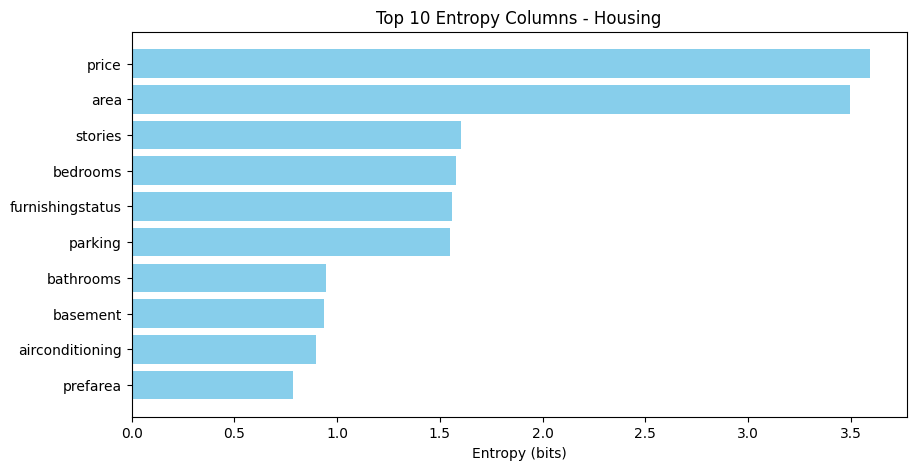

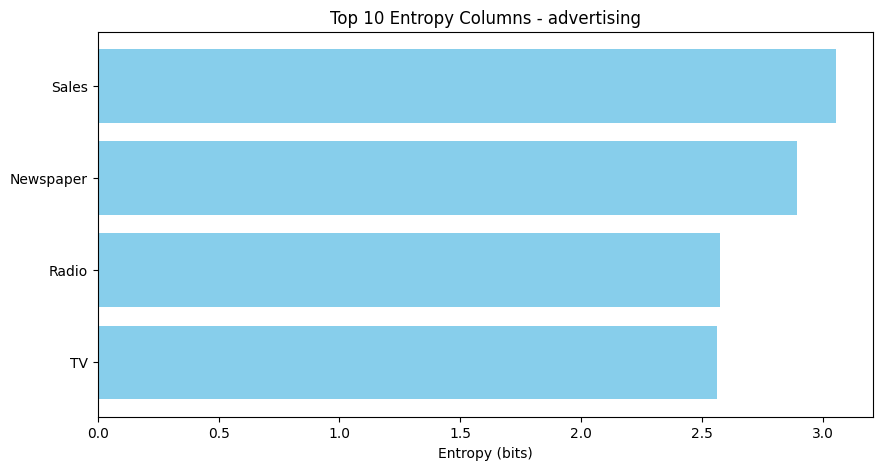

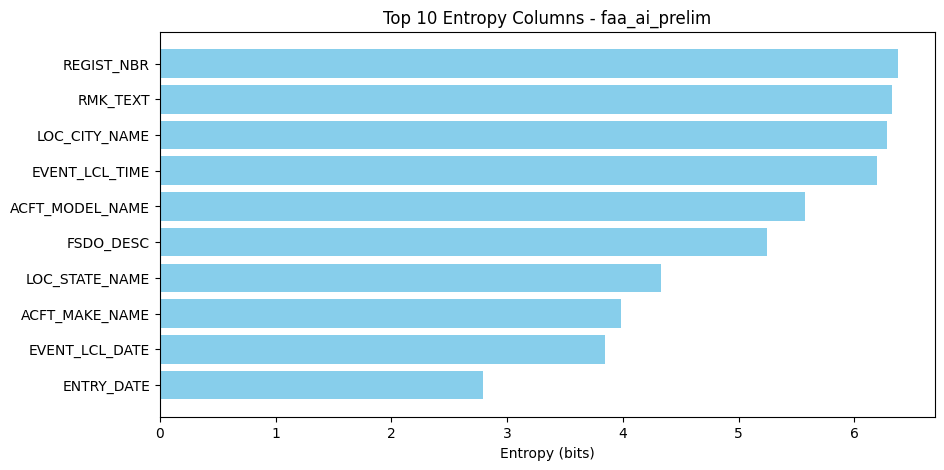

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import log2

# Helper functions

def entropy_from_counts(counts):
    """Compute Shannon entropy from counts."""
    probs = counts / counts.sum()
    probs = probs[probs > 0]  # avoid log(0)
    return -(probs * np.log2(probs)).sum()

def compute_column_entropy(series, treat_as=None, bins=10):
    """Compute entropy for a pandas Series (categorical or continuous)."""

    # Decide treatment if not given
    if treat_as is None:
        if series.dtype == 'object' or series.dtype.name == 'category' or series.nunique(dropna=False) <= 20:
            treat_as = 'categorical'
        else:
            treat_as = 'continuous'

    info = {'treatment': treat_as}

    if treat_as == 'categorical':
        counts = series.fillna('<<NA>>').value_counts()
        info['unique_values'] = counts.size
        info['entropy_bits'] = float(entropy_from_counts(counts.values))

    else:  # continuous
        arr = series.dropna().astype(float).values
        if arr.size == 0:
            info['unique_values'] = 0
            info['entropy_bits'] = float('nan')
            return info

        # Use Freedman–Diaconis rule for adaptive binning
        q75, q25 = np.percentile(arr, [75, 25])
        iqr = q75 - q25
        if iqr == 0:
            bins = int(np.sqrt(arr.size))
            bins = max(2, bins)
        else:
            bin_width = 2 * iqr * (arr.size ** (-1/3))
            span = arr.max() - arr.min()
            bins = int(np.ceil(span / bin_width)) if span > 0 else 1
            bins = max(2, bins)

        counts, bin_edges = np.histogram(arr, bins=bins)
        info['unique_values'] = int(len(bin_edges)-1)
        info['bins'] = bins
        info['entropy_bits'] = float(entropy_from_counts(counts))

    return info


# Load datasets
files = {
    "advertising": "advertising.csv",
    "Housing": "Housing.csv",
    "faa_ai_prelim": "faa_ai_prelim.csv"
}

results = []

for name, path in files.items():
    df = pd.read_csv(path)

    for col in df.columns:
        series = df[col]

        # Decide categorical vs continuous
        if series.dtype == 'object' or series.dtype.name == 'category' or series.nunique(dropna=False) <= 20:
            treat = 'categorical'
        else:
            treat = 'continuous'

        info = compute_column_entropy(series, treat_as=treat)

        results.append({
            "file": name,
            "column": col,
            "treatment": info.get('treatment'),
            "unique_or_bins": info.get('unique_values'),
            "bins_used": info.get('bins', np.nan),
            "entropy_bits": info.get('entropy_bits')
        })


# Results table

res_df = pd.DataFrame(results).sort_values(['file','entropy_bits'], ascending=[True, False]).reset_index(drop=True)
display(res_df)


# Optional: Plot entropy bar charts

for dataset in res_df['file'].unique():
    subset = res_df[res_df['file'] == dataset].sort_values("entropy_bits", ascending=False).head(10)
    plt.figure(figsize=(10,5))
    plt.barh(subset['column'], subset['entropy_bits'], color='skyblue')
    plt.xlabel("Entropy (bits)")
    plt.title(f"Top 10 Entropy Columns - {dataset}")
    plt.gca().invert_yaxis()
    plt.show()
